# Input: 
- flights_nullsremoved.csv
- weather_data_complete.csv

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.  
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?
​

Steps: 
- Step 1: Confirm hypothesis: The delay type only filled out for delays above 15min
- Step 2: Get class representations
- Step 3: Get the weather for flights that have been delayed because of weather
- Step 4: Get average delay per weather type
- Step 5: Look at their distributions

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('flights_nullsremoved.csv')

C:\Users\derob\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15878857 entries, 0 to 15878856
Data columns (total 41 columns):
 #   Column               Dtype  
---  ------               -----  
 0   fl_date              object 
 1   mkt_unique_carrier   object 
 2   branded_code_share   object 
 3   mkt_carrier          object 
 4   mkt_carrier_fl_num   int64  
 5   op_unique_carrier    object 
 6   tail_num             object 
 7   op_carrier_fl_num    int64  
 8   origin_airport_id    int64  
 9   origin               object 
 10  origin_city_name     object 
 11  dest_airport_id      int64  
 12  dest                 object 
 13  dest_city_name       object 
 14  crs_dep_time         int64  
 15  dep_time             float64
 16  dep_delay            float64
 17  taxi_out             float64
 18  wheels_off           float64
 19  wheels_on            float64
 20  taxi_in              float64
 21  crs_arr_time         int64  
 22  arr_time             float64
 23  arr_delay            float64
 

## Step 1: Confirm hypothesis: The delay type only filled out for delays above 15min

In [5]:
# filter data with flights only 15min or higher 
df = df[df.arr_delay >= 15]
print(len(df))

3008192


In [6]:
# see if there are flights with no reporting causes among them - only consider no
len(df[(df.carrier_delay == 0) & (df.weather_delay == 0) & (df.nas_delay == 0) & (df.security_delay == 0) & (df.late_aircraft_delay == 0)])

2

In [7]:
# fill delay_type with column name corresponding to max_delay
df['max_delay'] = df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].idxmax(axis=1)

## Step 2: Get class representations

In [8]:
# get class representations - what's the data with only zeros?
for c in df['max_delay'].unique():
    print(f'{c}: {len(df[df.max_delay == c])} values, {round(len(df[df.max_delay == c])/len(df)*100,2)} %')

late_aircraft_delay: 1179556 values, 39.21 %
carrier_delay: 804709 values, 26.75 %
nas_delay: 917411 values, 30.5 %
weather_delay: 101376 values, 3.37 %
security_delay: 5140 values, 0.17 %


In [197]:
#!!!!!!!!!!!!!!!!!!!!!!!! could plot this
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!! plot average arrival delays for each too

In [9]:
# get a database with only weather related delays. Selected >= 0 here to filter out early flights
flights_weather_delay = df[df.weather_delay > 0] 
flights_weather_delay.shape

(181935, 42)

In [10]:
# get only features we're interested in
flights_weather_delay = flights_weather_delay[['fl_date', 'weather_delay', 'dest_city_name']]

In [11]:
flights_weather_delay.head()

,fl_date,weather_delay,dest_city_name
241,2018-11-26,960.0,"San Francisco, CA"
251,2018-11-26,85.0,"Boston, MA"
266,2018-11-26,26.0,"Orlando, FL"
277,2018-11-26,139.0,"Chicago, IL"
280,2018-11-26,14.0,"Dallas/Fort Worth, TX"


## Step 3: Get the weather for flights that have been delayed because of weather
### 3.1 Get weather data from Visual Crossing

In [128]:
# get weather data from EAST cohort
# this gives us the weather for each city and for each day of 2018-2019
weather = pd.read_csv('weather_data_complete.csv')

In [13]:
weather.columns

Index(['Date', 'Juneau, AK', 'Raleigh/Durham, NC', 'Charlotte, NC',
       'Columbus, OH', 'Harlingen/San Benito, TX', 'Barrow, AK',
       'Fayetteville, NC', 'Cordova, AK', 'Bloomington/Normal, IL',
       ...
       'Mission/McAllen/Edinburg, TX', 'Traverse City, MI', 'Honolulu, HI',
       'Bethel, AK', 'Williston, ND', 'Columbus, MS', 'Salisbury, MD',
       'San Antonio, TX', 'Charleston, SC', 'Oakland, CA'],
      dtype='object', length=365)

In [14]:
weather.head()

,Date,"Juneau, AK","Raleigh/Durham, NC","Charlotte, NC","Columbus, OH","Harlingen/San Benito, TX","Barrow, AK","Fayetteville, NC","Cordova, AK","Bloomington/Normal, IL",...,"Mission/McAllen/Edinburg, TX","Traverse City, MI","Honolulu, HI","Bethel, AK","Williston, ND","Columbus, MS","Salisbury, MD","San Antonio, TX","Charleston, SC","Oakland, CA"
0,2018-01-01,{'Clear'},{'Partially cloudy'},{'Partially cloudy'},"{'Snow, Partially cloudy'}","{'Rain, Overcast'}",{'Overcast'},{'Clear'},{'Snow'},{'Clear'},...,"{'Rain, Overcast'}","{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Clear'},{'Clear'},{'Clear'},{'Overcast'},{'Clear'},{'Clear'}
1,2018-01-02,{'Clear'},{'Clear'},{'Clear'},"{'Snow, Partially cloudy'}","{'Rain, Overcast'}",{'Partially cloudy'},{'Clear'},{'Rain'},{'Clear'},...,"{'Rain, Overcast'}","{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Overcast'},{'Clear'},{'Clear'}
2,2018-01-03,{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},"{'Snow, Partially cloudy'}",{'Partially cloudy'},{'Overcast'},{'Partially cloudy'},{'Rain'},{'Partially cloudy'},...,{'Clear'},"{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},"{'Rain, Partially cloudy'}",{'Clear'},{'Clear'},{'Clear'}
3,2018-01-04,{'Clear'},"{'Snow, Partially cloudy'}",{'Clear'},"{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Snow'},{'Clear'},{'Partially cloudy'},...,{'Clear'},"{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Overcast'},{'Clear'},"{'Rain, Partially cloudy'}",{'Clear'},{'Clear'},{'Clear'}
4,2018-01-05,{'Rain'},{'Clear'},{'Clear'},"{'Snow, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Clear'},{'Partially cloudy'},...,{'Partially cloudy'},"{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Overcast'},{'Clear'},{'Clear'},{'Partially cloudy'},{'Clear'},{'Clear'}


### 3.2 Append weather delay information to database
Pseudo code:  
Transform weather dataframe to have a multi intex date & city name   
Transform flights dataframe to have multi index date & city name    
Left join weather on flights  

3.2.1 Transform weather dataframe to have a multi intex date & city name  
Working with flights_weather_delay and weather databases

In [ ]:
weather = pd.read_csv('weather_data_complete.csv')

In [129]:
weather.head()

,Date,"Juneau, AK","Raleigh/Durham, NC","Charlotte, NC","Columbus, OH","Harlingen/San Benito, TX","Barrow, AK","Fayetteville, NC","Cordova, AK","Bloomington/Normal, IL",...,"Mission/McAllen/Edinburg, TX","Traverse City, MI","Honolulu, HI","Bethel, AK","Williston, ND","Columbus, MS","Salisbury, MD","San Antonio, TX","Charleston, SC","Oakland, CA"
0,2018-01-01,{'Clear'},{'Partially cloudy'},{'Partially cloudy'},"{'Snow, Partially cloudy'}","{'Rain, Overcast'}",{'Overcast'},{'Clear'},{'Snow'},{'Clear'},...,"{'Rain, Overcast'}","{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Clear'},{'Clear'},{'Clear'},{'Overcast'},{'Clear'},{'Clear'}
1,2018-01-02,{'Clear'},{'Clear'},{'Clear'},"{'Snow, Partially cloudy'}","{'Rain, Overcast'}",{'Partially cloudy'},{'Clear'},{'Rain'},{'Clear'},...,"{'Rain, Overcast'}","{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Overcast'},{'Clear'},{'Clear'}
2,2018-01-03,{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},"{'Snow, Partially cloudy'}",{'Partially cloudy'},{'Overcast'},{'Partially cloudy'},{'Rain'},{'Partially cloudy'},...,{'Clear'},"{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},"{'Rain, Partially cloudy'}",{'Clear'},{'Clear'},{'Clear'}
3,2018-01-04,{'Clear'},"{'Snow, Partially cloudy'}",{'Clear'},"{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Snow'},{'Clear'},{'Partially cloudy'},...,{'Clear'},"{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Overcast'},{'Clear'},"{'Rain, Partially cloudy'}",{'Clear'},{'Clear'},{'Clear'}
4,2018-01-05,{'Rain'},{'Clear'},{'Clear'},"{'Snow, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Clear'},{'Partially cloudy'},...,{'Partially cloudy'},"{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Overcast'},{'Clear'},{'Clear'},{'Partially cloudy'},{'Clear'},{'Clear'}


In [130]:
#format dataframe
weather = weather.set_index(keys='Date')
weather = pd.DataFrame(weather.stack())
weather.index.names = ['fl_date', 'dest_city_name']
weather.columns = ['weather']
weather.head()

weather
fl_date    dest_city_name                                      
2018-01-01 Juneau, AK                                 {'Clear'}
           Raleigh/Durham, NC              {'Partially cloudy'}
           Charlotte, NC                   {'Partially cloudy'}
           Columbus, OH              {'Snow, Partially cloudy'}
           Harlingen/San Benito, TX          {'Rain, Overcast'}

In [134]:
# cleanup values
weather['weather_new'] = ''
weather.loc[weather.weather_new == '', 'weather_new'] = weather.weather.str.split(',').str.get(0)
weather.weather_new = weather.weather_new.map(lambda x: x.lstrip('{'))
weather.weather_new = weather.weather_new.map(lambda x: x.rstrip("'}"))
weather.weather_new = weather.weather_new.map(lambda x: x.strip("'"))
weather.head()

weather  \
fl_date    dest_city_name                                         
2018-01-01 Juneau, AK                                 {'Clear'}   
           Raleigh/Durham, NC              {'Partially cloudy'}   
           Charlotte, NC                   {'Partially cloudy'}   
           Columbus, OH              {'Snow, Partially cloudy'}   
           Harlingen/San Benito, TX          {'Rain, Overcast'}   

                                          weather_new  
fl_date    dest_city_name                              
2018-01-01 Juneau, AK                           Clear  
           Raleigh/Durham, NC        Partially cloudy  
           Charlotte, NC             Partially cloudy  
           Columbus, OH                          Snow  
           Harlingen/San Benito, TX              Rain

3.2.2 Transform flights dataframe to have multi index date & city name

In [135]:
flights_weather_delay.head()

,fl_date,weather_delay,dest_city_name
241,2018-11-26,960.0,"San Francisco, CA"
251,2018-11-26,85.0,"Boston, MA"
266,2018-11-26,26.0,"Orlando, FL"
277,2018-11-26,139.0,"Chicago, IL"
280,2018-11-26,14.0,"Dallas/Fort Worth, TX"


In [136]:
# format dataframe
flights_weather_delay_day.groupby(['fl_date', 'dest_city_name']).sum()
flights_weather_delay.head()

,fl_date,weather_delay,dest_city_name
241,2018-11-26,960.0,"San Francisco, CA"
251,2018-11-26,85.0,"Boston, MA"
266,2018-11-26,26.0,"Orlando, FL"
277,2018-11-26,139.0,"Chicago, IL"
280,2018-11-26,14.0,"Dallas/Fort Worth, TX"


3.2.3 Join weather on flights 

In [139]:
data_merged = pd.merge(flights_weather_delay, weather, on=['fl_date', 'dest_city_name'], how='inner').drop('weather', axis=1)

In [140]:
data_merged.head()

,fl_date,weather_delay,dest_city_name,weather_new
0,2018-11-26,960.0,"San Francisco, CA",Clear
1,2018-11-26,267.0,"San Francisco, CA",Clear
2,2018-11-26,1.0,"San Francisco, CA",Clear
3,2018-11-26,7.0,"San Francisco, CA",Clear
4,2018-11-26,42.0,"San Francisco, CA",Clear


In [168]:
# keep only values where we have the weaher data
data_merged = data_merged[data_merged.weather_new != '']

In [169]:
data_merged.dropna()['weather_new'].unique()

array(['Clear', 'Rain', 'Snow', 'Partially cloudy', 'Overcast'],
      dtype=object)

### Step 4: Get average delay per weather type

In [170]:
db_delay_per_type = pd.DataFrame(data_merged.groupby('weather_new')['weather_delay'].mean())
db_delay_per_type.reset_index()

,weather_new,weather_delay
0,Clear,57.022155
1,Overcast,53.940169
2,Partially cloudy,57.001339
3,Rain,63.104916
4,Snow,87.754630


Text(0.5, 1.0, 'Average weather caused arrival delays per weather type')

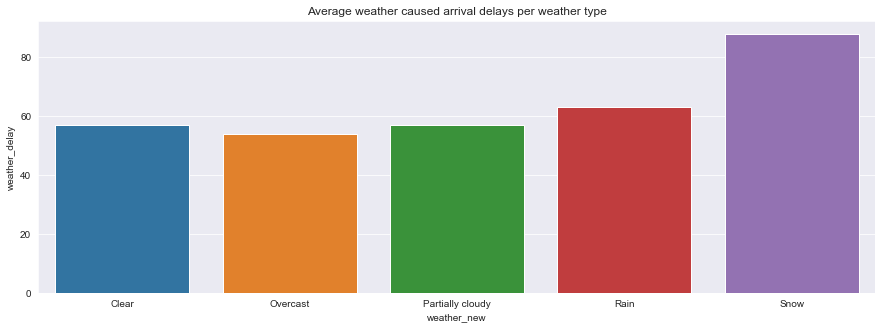

In [193]:
# plot it

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=db_delay_per_type.reset_index(), x='weather_new', y='weather_delay')
ax.set_title('Average weather caused arrival delays per weather type')

### Step 5: Look at their distributions

In [178]:
dist_clear = data_merged[data_merged.weather_new == 'Clear']
dist_overcast = data_merged[data_merged.weather_new == 'Overcast']
dist_pc = data_merged[data_merged.weather_new == 'Partially cloudy']
dist_rain = data_merged[data_merged.weather_new == 'Rain']
dist_snow = data_merged[data_merged.weather_new == 'Snow']

Text(0, 0.5, 'Density')

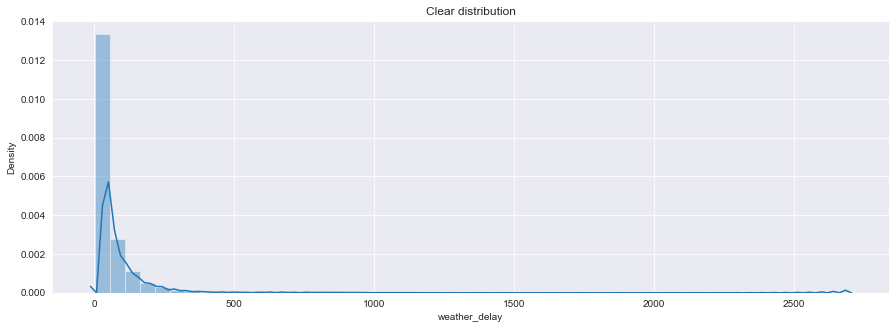

In [189]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_clear.weather_delay)
ax.set_title('Clear distribution')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

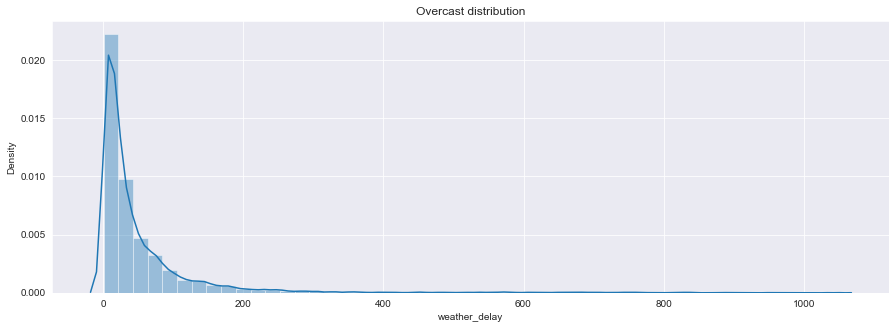

In [190]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_overcast.weather_delay)
ax.set_title('Overcast distribution')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

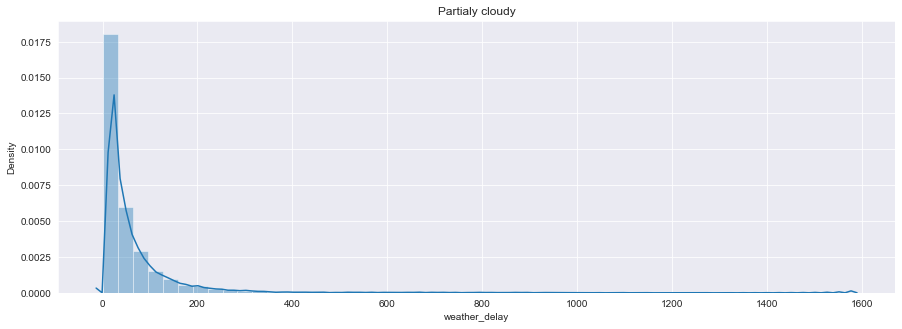

In [191]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_pc.weather_delay)
ax.set_title('Partialy cloudy')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

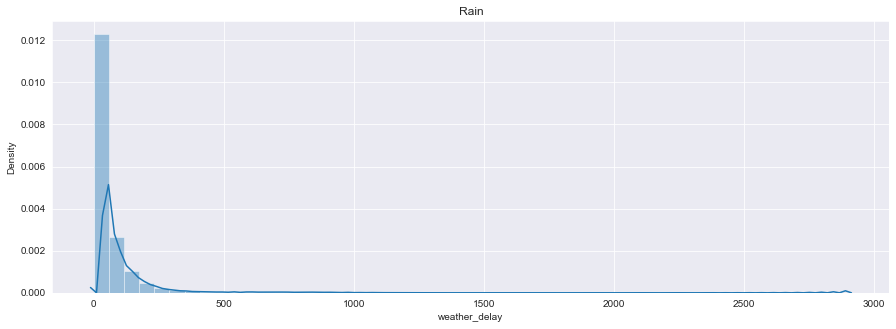

In [194]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_rain.weather_delay)
ax.set_title('Rain')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

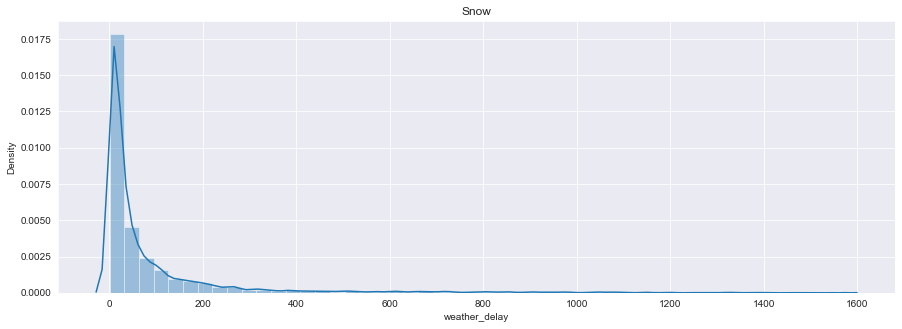

In [196]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_snow.weather_delay)
ax.set_title('Snow')
ax.set_ylabel('Density')

In [204]:
# remove outliars and plot again
data_merged = data_merged[data_merged.weather_delay < 200]
dist_clear = data_merged[data_merged.weather_new == 'Clear']
dist_overcast = data_merged[data_merged.weather_new == 'Overcast']
dist_pc = data_merged[data_merged.weather_new == 'Partially cloudy']
dist_rain = data_merged[data_merged.weather_new == 'Rain']
dist_snow = data_merged[data_merged.weather_new == 'Snow']

Text(0, 0.5, 'Density')

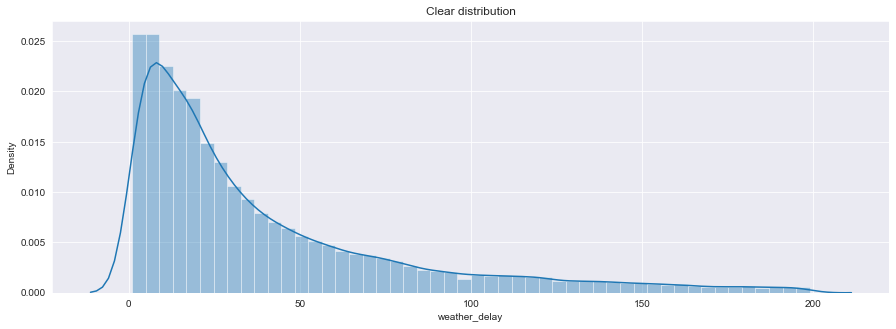

In [205]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_clear.weather_delay)
ax.set_title('Clear distribution')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

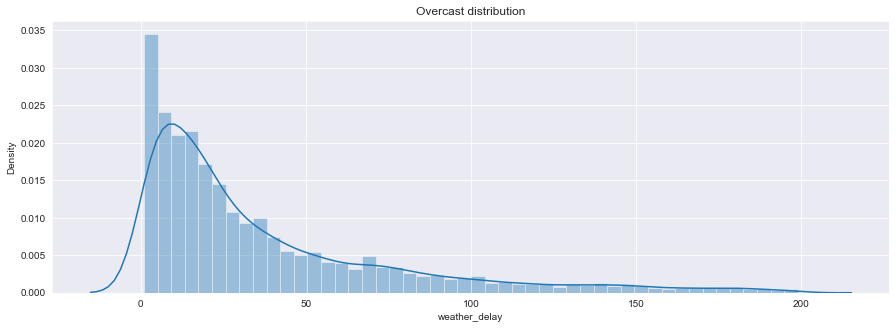

In [206]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_overcast.weather_delay)
ax.set_title('Overcast distribution')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

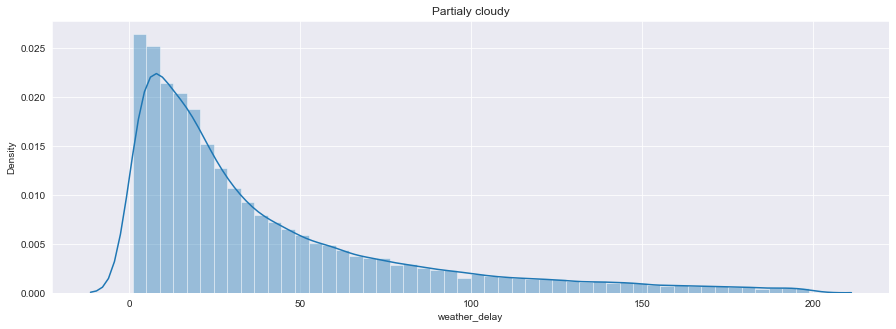

In [207]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_pc.weather_delay)
ax.set_title('Partialy cloudy')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

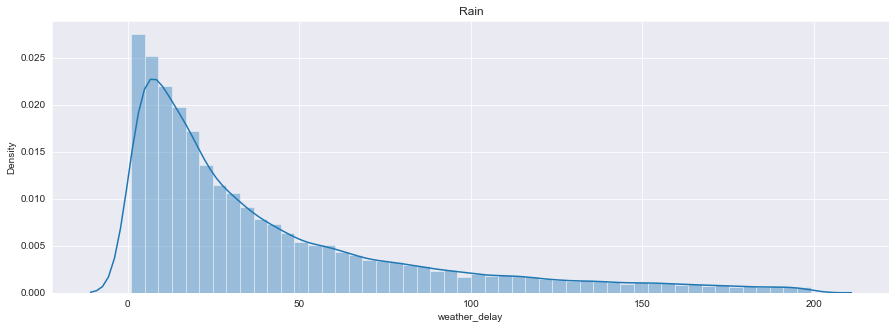

In [208]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_rain.weather_delay)
ax.set_title('Rain')
ax.set_ylabel('Density')

Text(0, 0.5, 'Density')

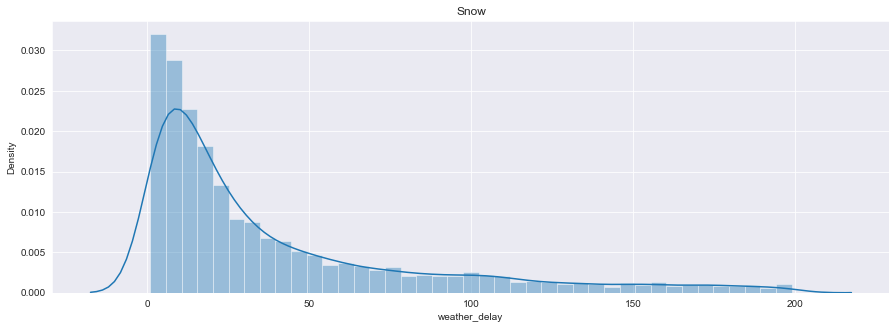

In [209]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(dist_snow.weather_delay)
ax.set_title('Snow')
ax.set_ylabel('Density')